In [7]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [8]:
colour_list = ["#c8274c","#f25546","#F06543","#e96e33","#f0b038","#FFE74C",
               "#69b944","#72b286","#69b0bc","#619ee4","#4b5bbb"][::-1]
from matplotlib.colors import LinearSegmentedColormap
cmap_iam = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
cmap_iam.set_bad('wheat')

In [9]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [10]:
def get_vars(dirname, dep_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    time_ind = 24*13
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][:time_ind, dep_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:time_ind, 0, 0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, dep_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, sozotaux, deptht, tmask

In [11]:
def get_1day_avg(sal, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    sal_day = np.mean(sal[day, ...], axis=0)
    return sal_day

In [12]:
def get_daily_vosaline(vosaline, tmask):
    
    # get daily salinity averages from hourly results
    vosaline_daily0 = np.full((vosaline.shape[-3]/24, vosaline.shape[-2], vosaline.shape[-1]), np.nan)
    for i in range(vosaline_daily0.shape[0]):
        day_start, day_end = i, i+1
        vosaline_daily0[i, :, :] = get_1day_avg(vosaline, day_start, day_end)

    tmask_new = np.tile(tmask[0, :, :, :], (vosaline_daily0.shape[0], 1, 1))
    vosaline_daily = np.ma.array(vosaline_daily0, mask=1 - tmask_new)

    print(type(vosaline_daily0), vosaline_daily0.shape, tmask_new.shape, vosaline_daily.shape, type(vosaline_daily))
    
    return vosaline_daily, tmask_new

In [13]:
def get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile):
    
    # trace back the deptht_ind where this_vosaline occured the vosaline_ref     
    deptht_ind_daily = np.full_like(vosaline_daily, np.nan, dtype=np.int)
    for t in range(deptht_ind_daily.shape[-3]):
        print(t)
        for y in range(deptht_ind_daily.shape[-2]):
            for x in range(deptht_ind_daily.shape[-1]):
                this_vosaline = vosaline_daily[t, y, x]
                deptht_ind_daily[t, y, x] = min(range(len(vosaline_ref_profile)), key=lambda i: abs(vosaline_ref_profile[i]-this_vosaline))

    print(deptht_ind_daily.shape, type(deptht_ind_daily))

    return deptht_ind_daily

In [14]:
def get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new):

    # get deptht for deptht_ind of origin
    deptht_m_daily0 = deptht[deptht_ind_daily]
    deptht_m_daily = np.ma.array(deptht_m_daily0, mask=1 - tmask_new)

    print(deptht_m_daily.shape, type(deptht_m_daily))
    
    return deptht_m_daily

In [15]:
def pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel):
    
    fig, axes = plt.subplots(3, 4, figsize = (20, 20))
    for ax, n in zip(axes.flatten(), np.arange(12)):  
        p = ax.pcolormesh(plot_array[n, :, :], cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, plot_array.shape[-1]])
        ax.set_ylim([0, plot_array.shape[-2]])
        ax.set_title('Day ' + str(n+1), fontsize=20)
        ax.axvline(130, c='k')
        #ax.axhline(65, c='k')
        if n == 0:
            cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
            cbar.set_label(cblabel, fontsize=18, rotation=0, labelpad=2.5)
            cbar.ax.tick_params(labelsize=13)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
        else:
            pass
    fig.tight_layout(w_pad=1.2, h_pad=0.01)
    fig.suptitle(title + ' [Depth = '+str(int(deptht[dep_ind]))+' m]', fontsize=25)
    plt.subplots_adjust(top=0.95)

    return fig

# Load salinity reference profile

In [16]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

# Depth index

In [17]:
dep_ind = 9

# Ideal_half

In [18]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [19]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
12
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


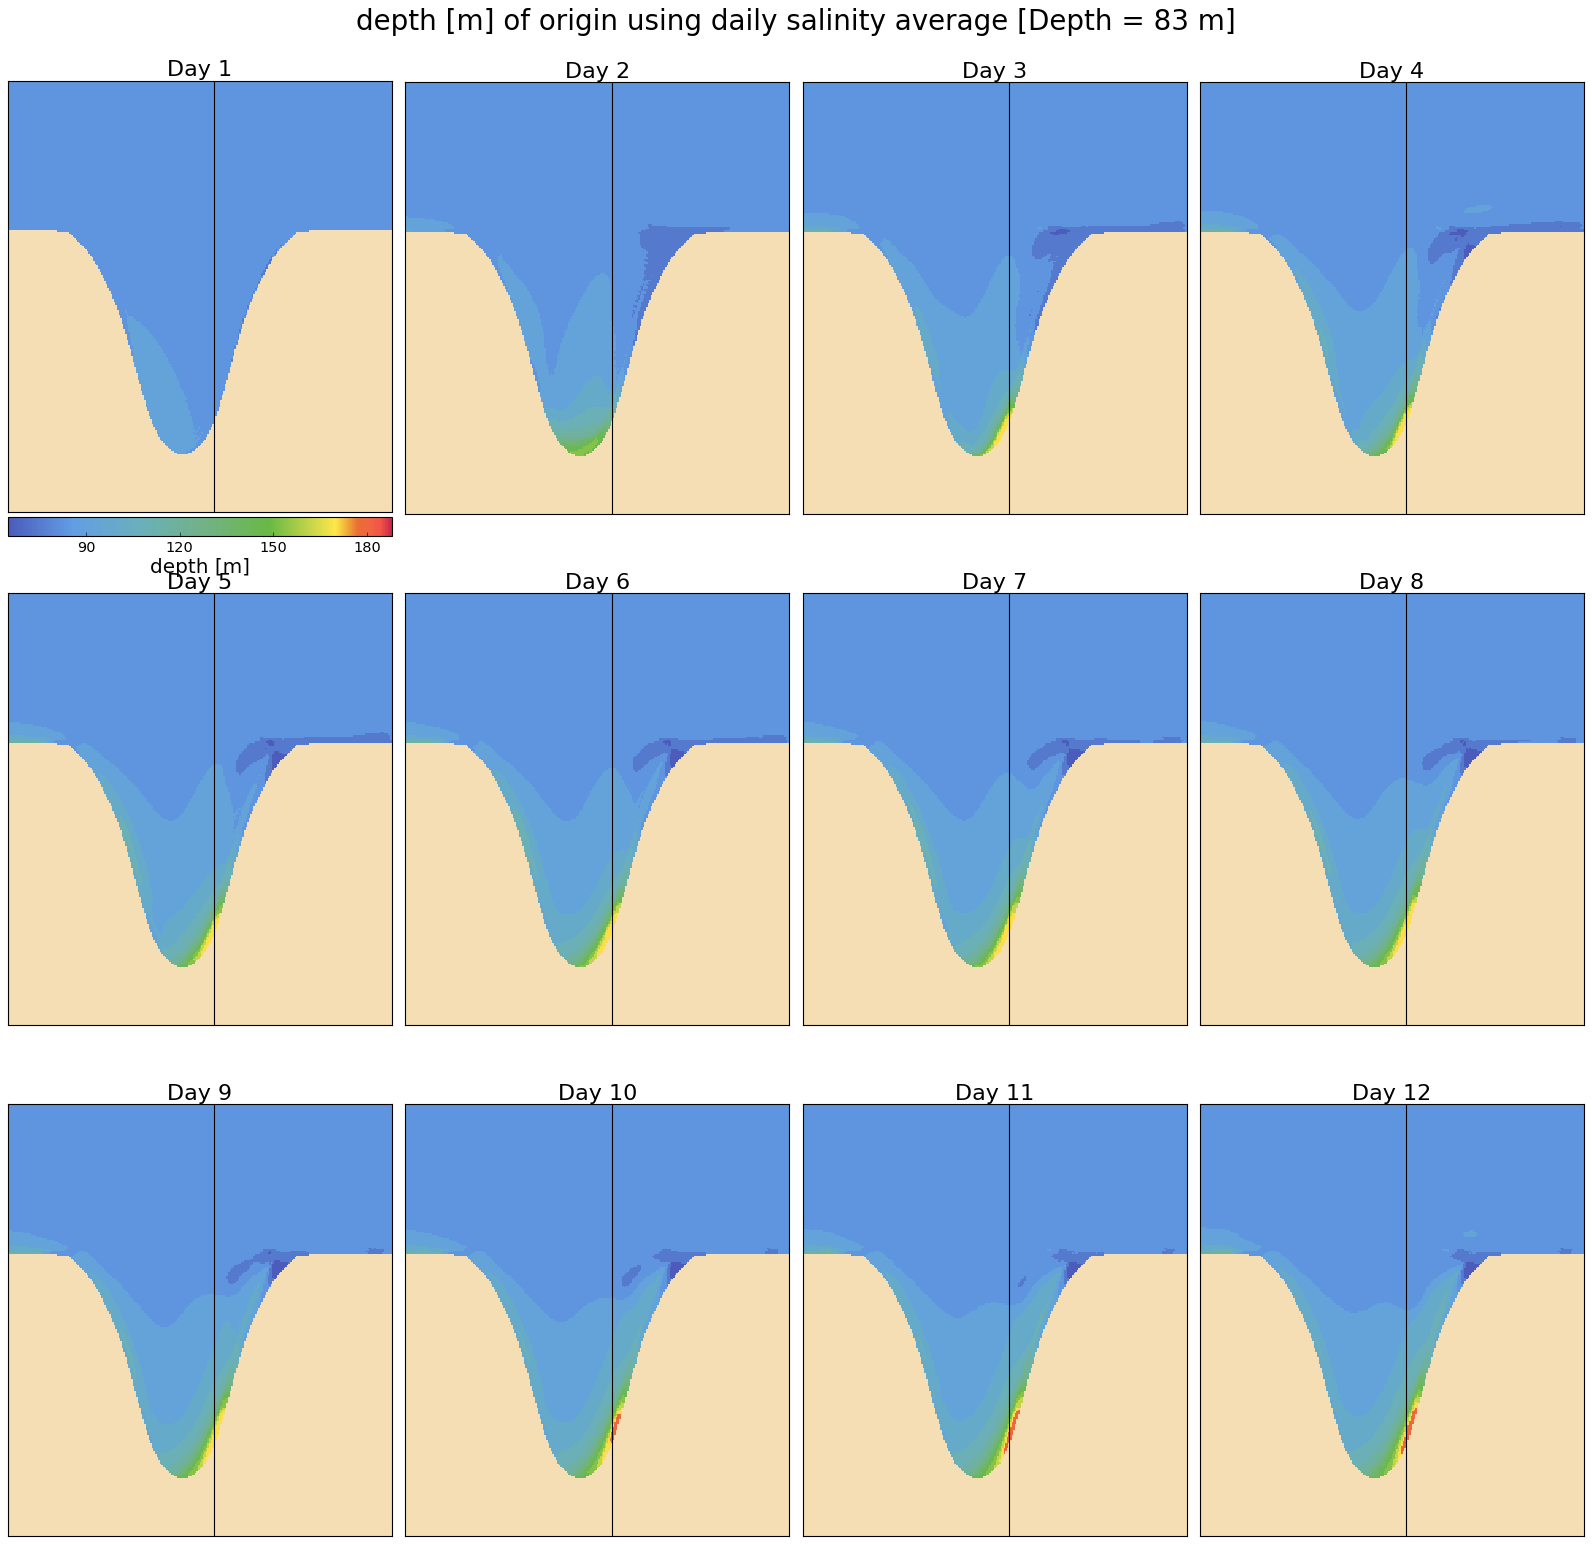

In [28]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, MidpointNormalize(midpoint=170)
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

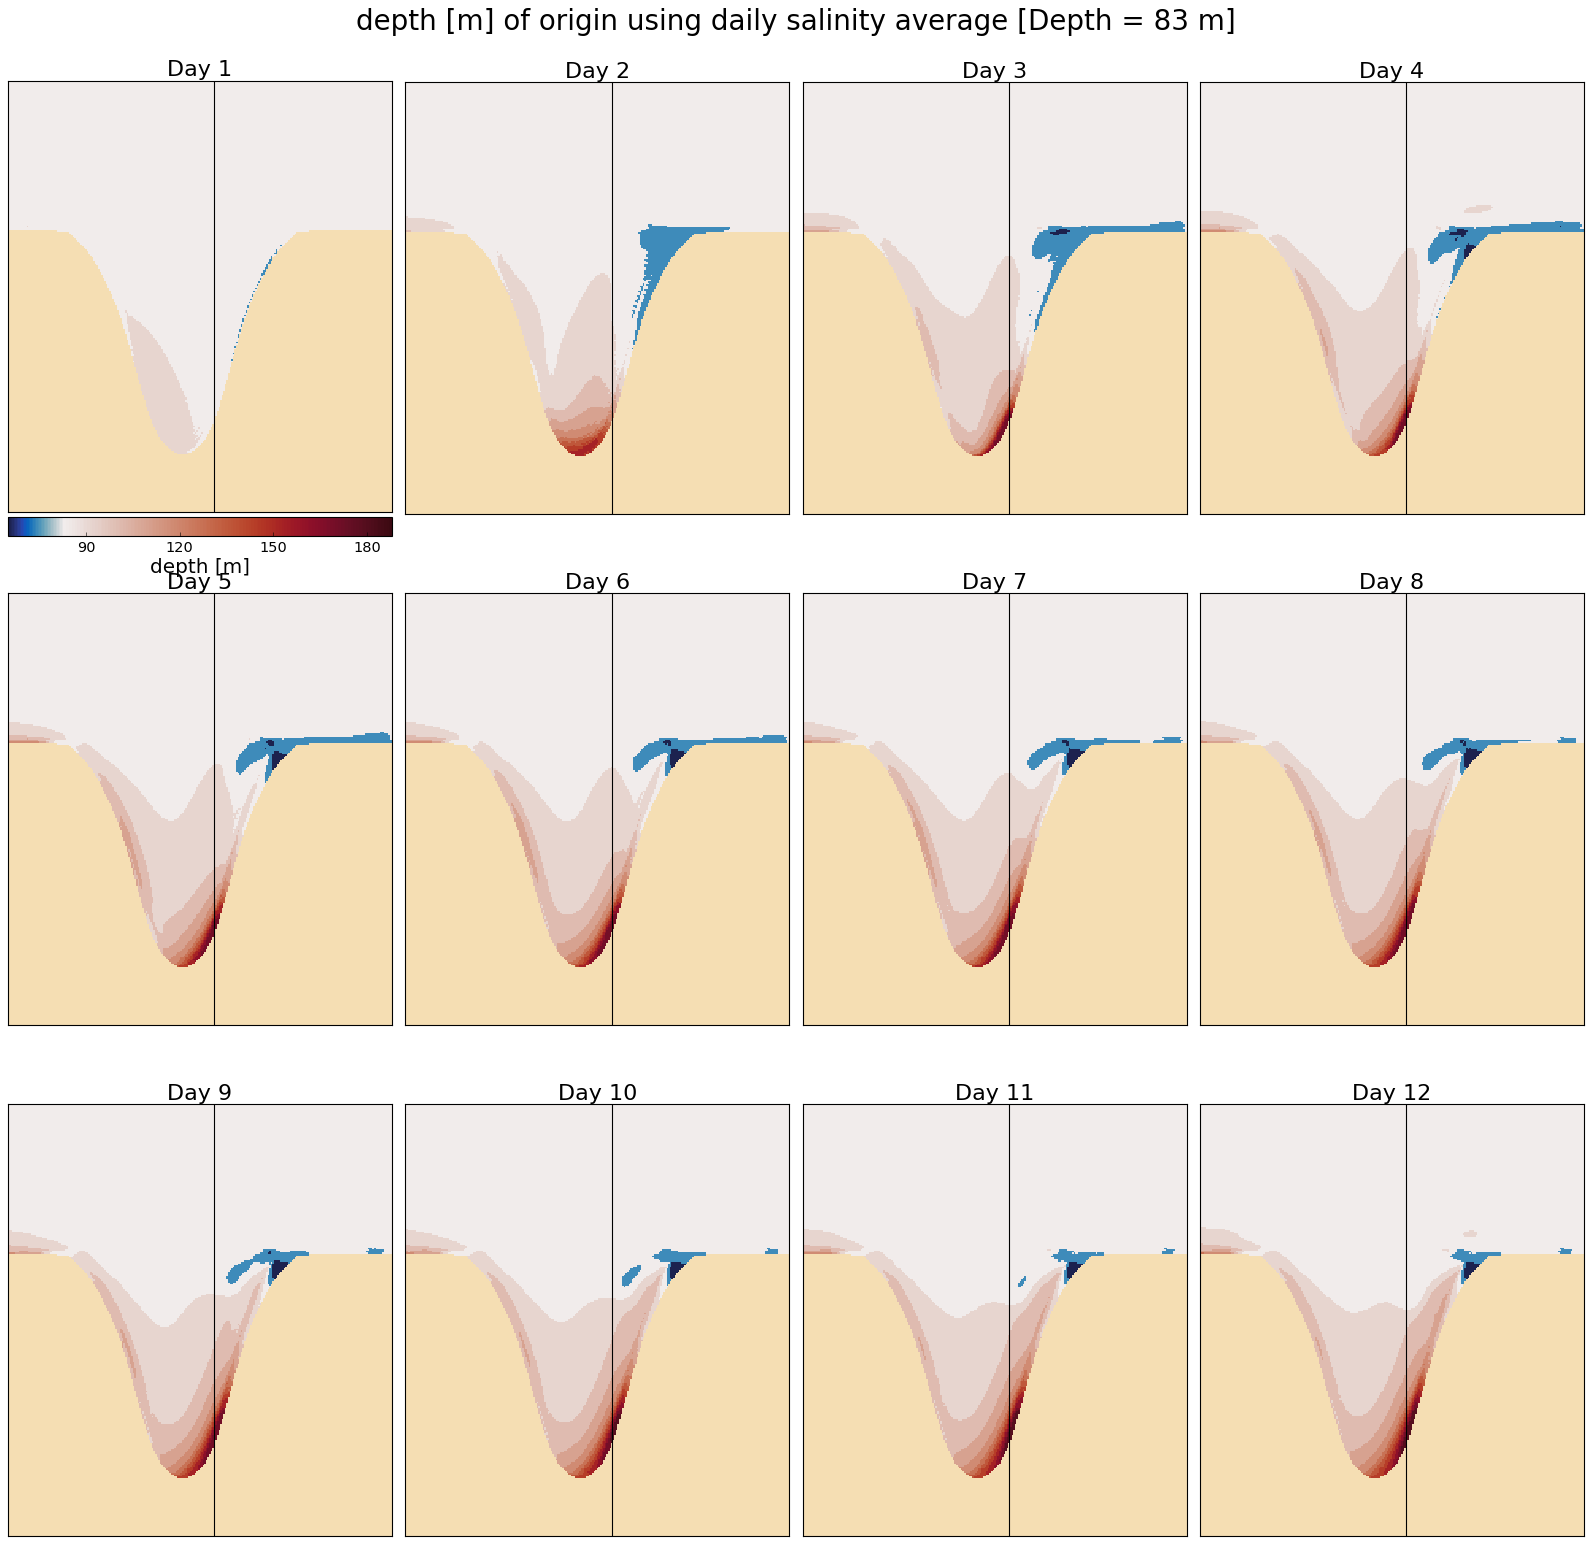

In [17]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

In [29]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d+1) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()) + ', max salinity ' +  str(vosaline_daily[d, :, :].max()))

day 1, ind 10, dep 91.875, max salinity 32.3599777222
day 2, ind 17, dep 153.125, max salinity 33.8990071615
day 3, ind 19, dep 170.625, max salinity 34.2004597982
day 4, ind 19, dep 170.625, max salinity 34.1512756348
day 5, ind 19, dep 170.625, max salinity 34.1382039388
day 6, ind 19, dep 170.625, max salinity 34.1899871826
day 7, ind 19, dep 170.625, max salinity 34.2044550578
day 8, ind 19, dep 170.625, max salinity 34.1931152344
day 9, ind 19, dep 170.625, max salinity 34.1937383016
day 10, ind 20, dep 179.375, max salinity 34.2186940511
day 11, ind 20, dep 179.375, max salinity 34.2527516683
day 12, ind 20, dep 179.375, max salinity 34.2846984863
day 13, ind 21, dep 188.125, max salinity 34.3295135498


# Ideal_base

In [30]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [31]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
12
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


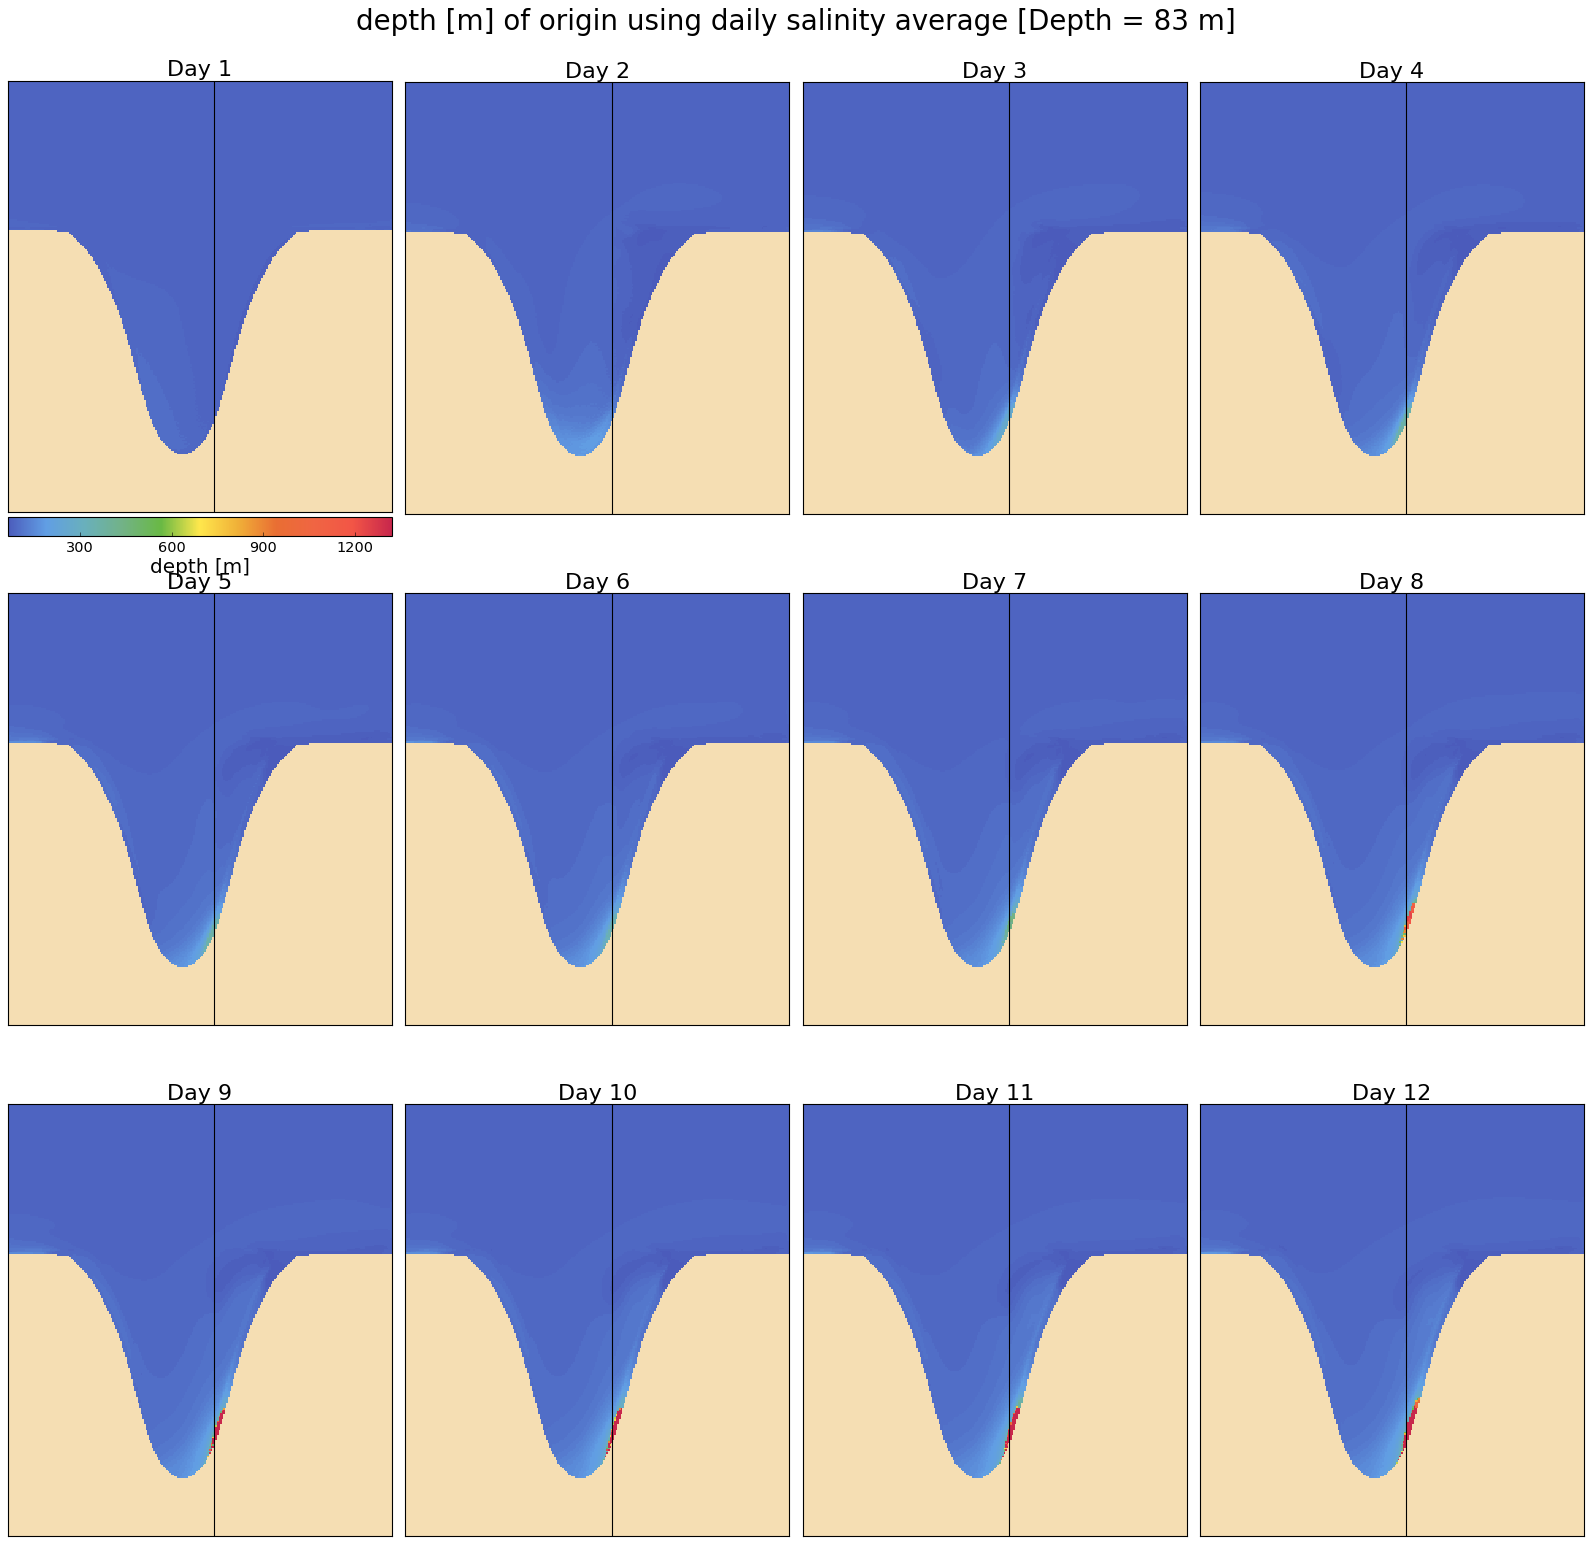

In [21]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, None
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

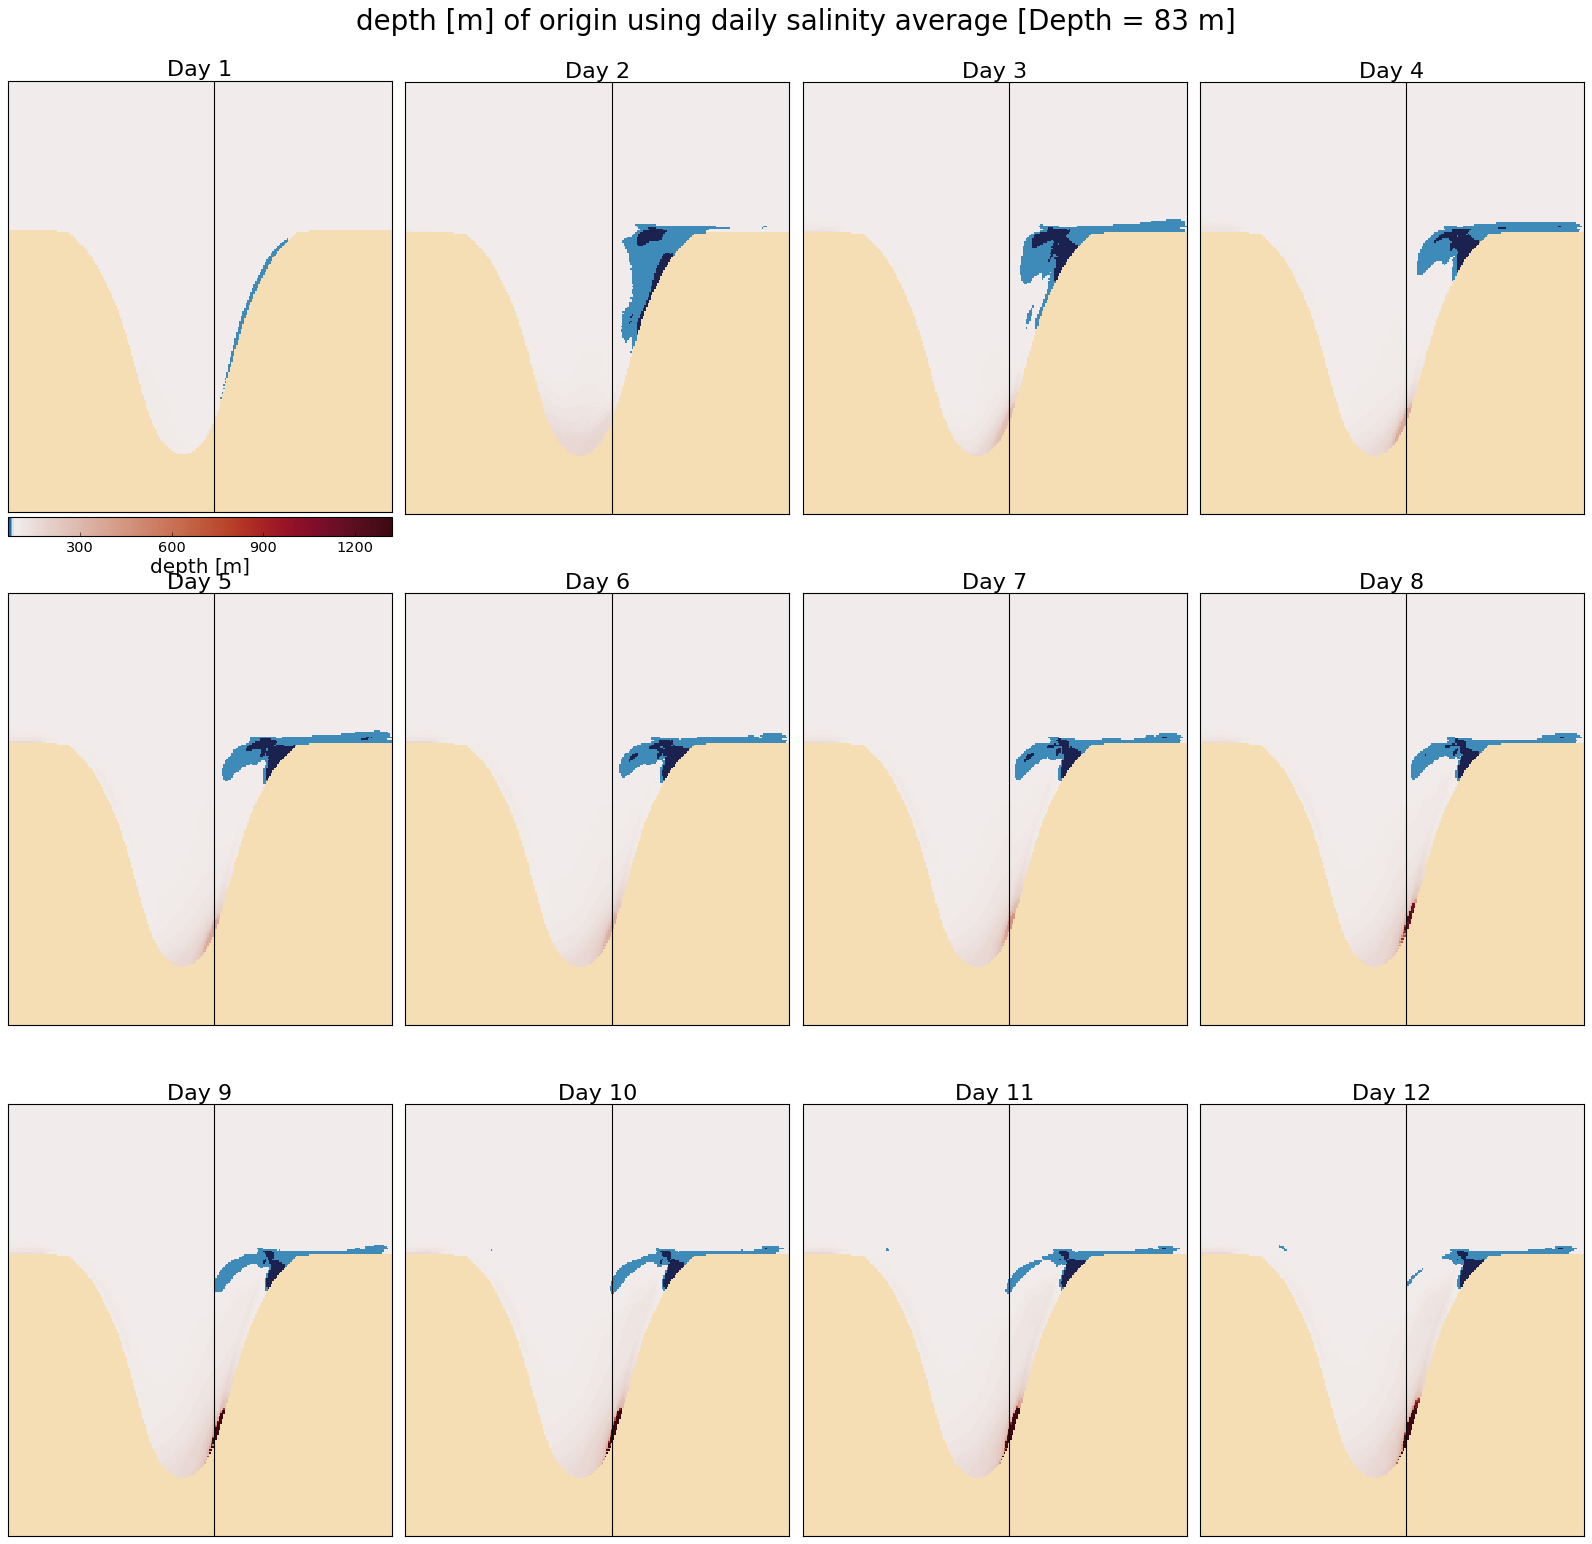

In [22]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

In [32]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d+1) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()) + ', max salinity ' +  str(vosaline_daily[d, :, :].max()))

day 1, ind 11, dep 100.625, max salinity 32.6218261719
day 2, ind 21, dep 188.125, max salinity 34.3679733276
day 3, ind 30, dep 266.875, max salinity 34.8271916707
day 4, ind 41, dep 363.125, max salinity 34.9574203491
day 5, ind 41, dep 363.125, max salinity 34.9564412435
day 6, ind 39, dep 345.625, max salinity 34.9427897135
day 7, ind 51, dep 450.625, max salinity 34.9860687256
day 8, ind 77, dep 1236.15, max salinity 35.0585403442
day 9, ind 79, dep 1321.28, max salinity 35.1180750529
day 10, ind 79, dep 1321.28, max salinity 35.1731236776
day 11, ind 79, dep 1321.28, max salinity 35.2245051066
day 12, ind 79, dep 1321.28, max salinity 35.2725957235
day 13, ind 79, dep 1321.28, max salinity 35.3430430094


# Ideal_double

In [25]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_double_flt/'
vosaline, sozotaux, deptht, tmask = get_vars(dirname, dep_ind)

In [26]:
vosaline_daily, tmask_new = get_daily_vosaline(vosaline, tmask)
deptht_ind_daily = get_daily_deptht_ind(vosaline_daily, vosaline_ref_profile)
deptht_m_daily = get_daily_deptht_m(deptht, deptht_ind_daily, tmask_new)

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
12
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>
(13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


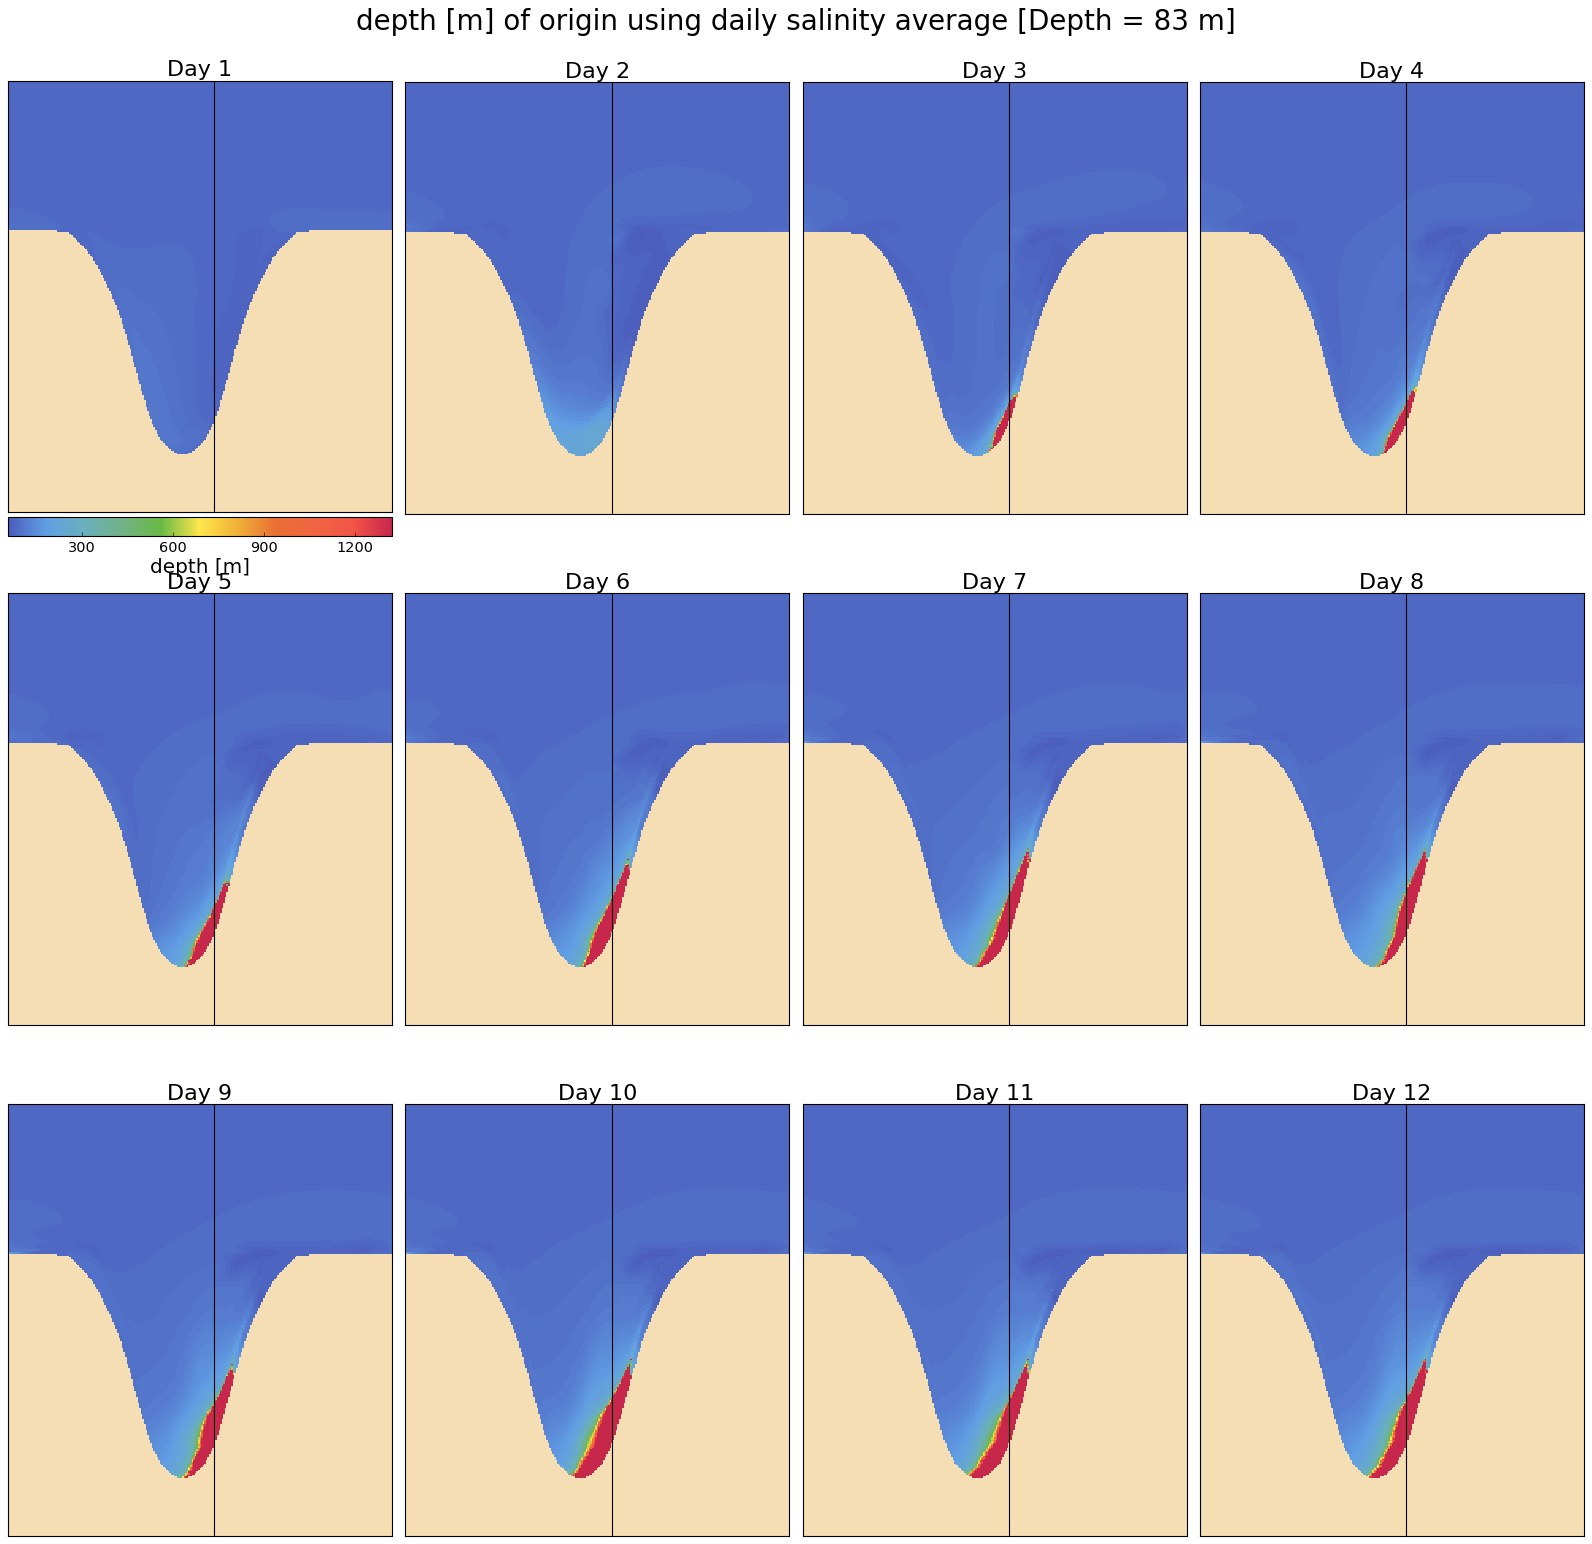

In [27]:
plot_array = deptht_m_daily
cmap, norm = cmap_iam, None
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

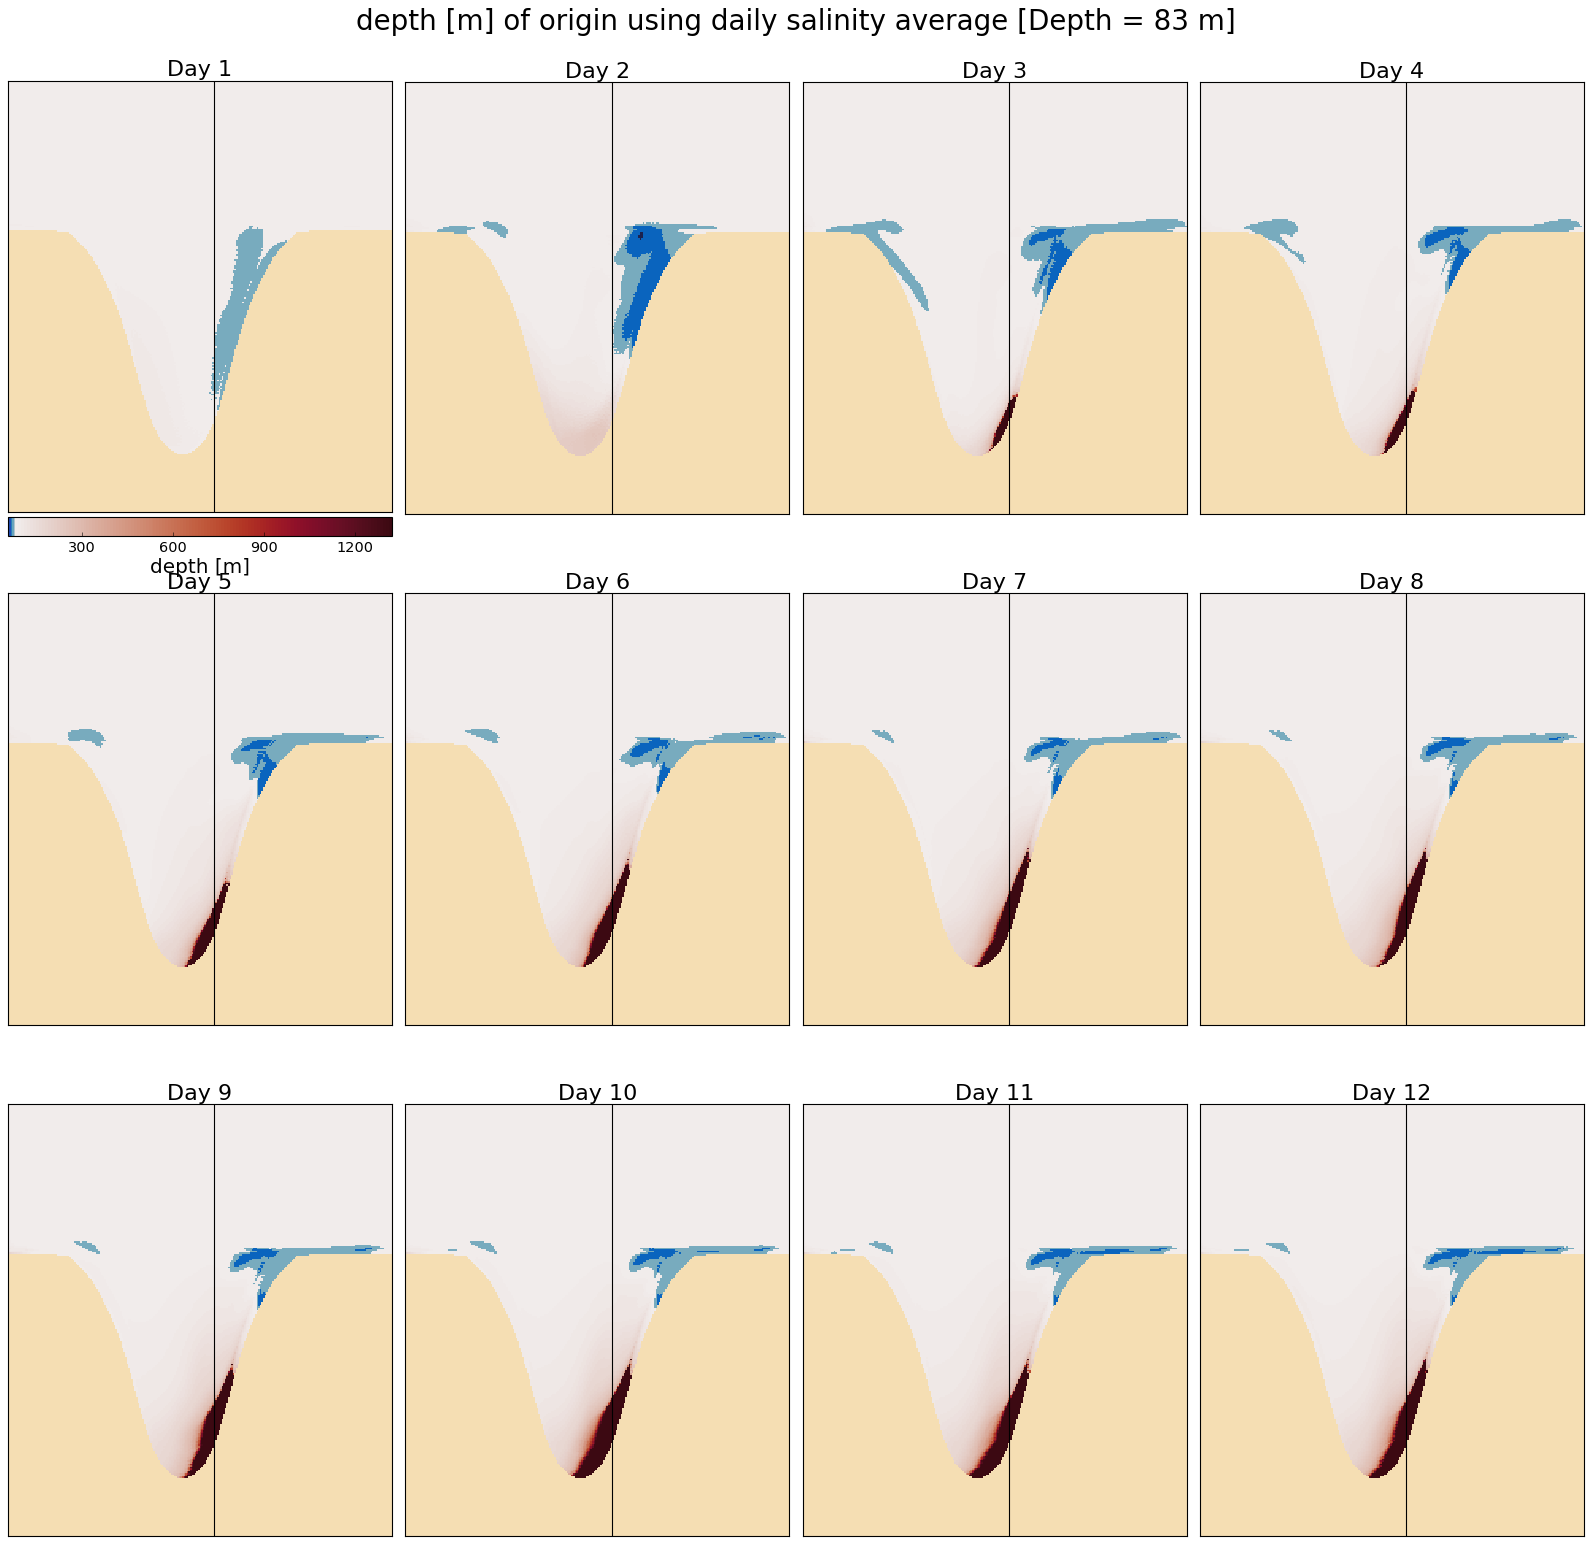

In [28]:
plot_array = deptht_m_daily
cmap, norm = cmo.cm.balance, MidpointNormalize(midpoint=deptht[dep_ind])
cmap.set_bad('wheat')
vmin, vmax = int(np.min(deptht_m_daily)), int(np.max(deptht_m_daily))
title, cblabel = 'depth [m] of origin using daily salinity average', 'depth [m]'
fig = pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel)

In [29]:
for d in range(deptht_ind_daily.shape[0]):
    print('day ' + str(d) + ', ind ' + str(deptht_ind_daily[d, :, :].max()) + ', dep ' +  str(deptht_m_daily[d, :, :].max()))

day 0, ind 12, dep 109.375
day 1, ind 28, dep 249.375
day 2, ind 79, dep 1321.28
day 3, ind 79, dep 1321.28
day 4, ind 79, dep 1321.28
day 5, ind 79, dep 1321.28
day 6, ind 79, dep 1321.28
day 7, ind 79, dep 1321.28
day 8, ind 79, dep 1321.28
day 9, ind 79, dep 1321.28
day 10, ind 79, dep 1321.28
day 11, ind 79, dep 1321.28
day 12, ind 79, dep 1321.28
